# Árboles de decisión y bosques aleatorios
**Nombre:** Juan Manuel Gutiérrez Gómez  **Código:** 2260563

Un Random Forest (Bosque Aleatorio), es una técnica de aprendizaje automático muy popular. Los Random Forests tienen una capacidad de generalización muy alta para muchos problemas.

Es uno de los algoritmos más utilizados debido a su precisión, simplicidad y flexibilidad. El hecho de que pueda usarse para tareas de clasificación y regresión, combinado con su naturaleza no lineal, lo hace altamente adaptable a una variedad de datos y situaciones.

Primero importamos las librerias principales que usaremos:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Creando un árbol de decisión 

Considere los siguientes datos bidimensionales, que tienen una de cuatro etiquetas de clase:

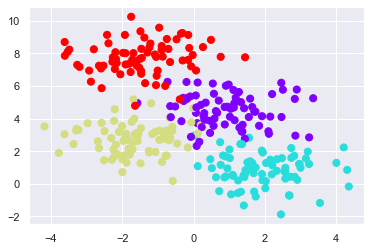

In [3]:
#Importamos make_blobs, esto genera puntos gaussianos isotrópicos
from sklearn.datasets import make_blobs

#Generamos los puntos tanto en X como en Y, seteamos la configuración
X, y = make_blobs(n_samples=300, centers=4,  
                  random_state=0, cluster_std=1.0)
#Graficamos
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

**Un árbol de decisiones es algo que usa en la vida de forma cotidiana**. A diario las personas tomamos decisiones sobre algún tema en especifico, las deciciones que se toman son porque llevan más peso y son las que tuvieron un valor más alto a la hora de decidir, en este caso sucede lo mismo, el algoritmo se encargará de dividir los puntos iteraticvamente asignandolos a una región  de acuerdo con el voto mayoritario de los puntos dentro de ella.

Este proceso de ajustar un árbol de decisión a nuestros datos se puede hacer en Scikit-Learn con el estimador DecisionTreeClassifier:

In [4]:
#Importamos el estimador DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
#Creamos un clasificador de árbol de decisiones a partir del conjunto de entrenamiento (X, y).
tree = DecisionTreeClassifier().fit(X, y)

Escribamos una función de utilidad rápida para ayudarnos a visualizar la salida del clasificador:

In [5]:
#Definimos una función para visualizar la clasificación, que en principio recibirá un modelo, y el entrenamiento (X, y) 
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    #Los ejes serán igual a los ejes pasados por parametro o a los ejes actuales en caso de que no se pasen como parámetro
    ax = ax or plt.gca()
    
    # Trazamos los puntos de entrenamiento
    # Se establecen las propiedades para trazar la dispersión
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # ajustamos el estimador
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Creamos un diagrama de color con los resultados.
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Ahora podemos examinar cómo se ve la clasificación del árbol de decisión:

C:\Users\JuanMa\AppData\Local\Temp\ipykernel_4320\2267876884.py:23: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


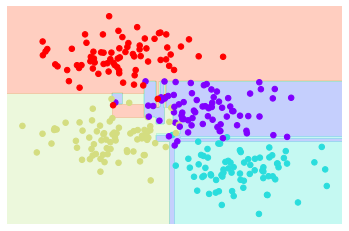

In [6]:
visualize_classifier(DecisionTreeClassifier(), X, y)

El siguiente código es una ayuda que nos permitirá interactuar con la gráfica y ver el proceso de creación del árbol de desición para nuestro ejercicio.

In [7]:
%%file helpers_05_08.py

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Trazar los puntos de entrenamiento
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # ajustar el estimador
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Poner el resultado en un diagrama de color.
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis', clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 5])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 100]);


Overwriting helpers_05_08.py


Importamos el **helper** y lo usamos para interactuar con la gráfica

In [8]:
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=1, options=(1, 5), value=5), Output()), _dom_classes…

Tenga en cuenta que a medida que aumenta la profundidad, tendemos a obtener regiones de clasificación de formas muy extrañas; por ejemplo, a una profundidad de cinco, hay una región morada alta y delgada entre las regiones amarilla y azul. Está claro que esto es menos el resultado de la verdadera distribución de datos intrínseca y más el resultado de las propiedades particulares de muestreo o ruido de los datos. Es decir, este árbol de decisiones, incluso con solo cinco niveles de profundidad, está claramente sobreajustado a nuestros datos.

## Árboles de decisión y sobreajuste

Siempre que haya suficientes árboles en el bosque, hay poco o ningún riesgo de sobreadaptación. Los árboles de decisión también pueden terminar sobreajustados. Los bosques aleatorios evitan eso al construir árboles de diferentes tamaños a partir de subconjuntos y combinar los resultados.

In [9]:
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

Así como el uso de información de dos árboles mejora nuestros resultados, podríamos esperar que el uso de información de muchos árboles mejoraría aún más nuestros resultados.

## Conjuntos de Estimadores: Bosques Aleatorios

Esta noción, que se pueden combinar múltiples estimadores de sobreajuste para reducir el efecto de este sobreajuste, es lo que subyace en un método de conjunto llamado embolsado. El embolsado utiliza un conjunto (quizás una bolsa sorpresa) de estimadores paralelos, cada uno de los cuales sobreajusta los datos y promedia los resultados para encontrar una mejor clasificación. Un conjunto de árboles de decisión aleatorios se conoce como bosque aleatorio.

Este tipo de clasificación de embolsado se puede realizar manualmente utilizando el metaestimador de Scikit-Learn BaggingClassifier, como se muestra aquí:

C:\Users\JuanMa\AppData\Local\Temp\ipykernel_4320\2267876884.py:23: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


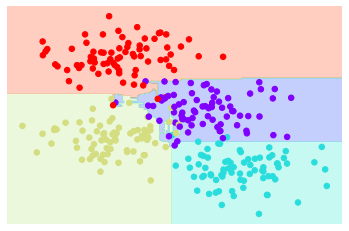

In [10]:
from sklearn.tree import DecisionTreeClassifier    #Importamos el estimador DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier     #Importamos el meta-estimador BaggingClassifier

#Creamos un clasificador de árbol de decisiones a partir del conjunto de entrenamiento (X, y).
tree = DecisionTreeClassifier()                    
#Creamos la 'bolsa' para aplicar el embolsado de nuestro arbol 'tree'
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)
#Ajustamos el estimador
bag.fit(X, y)
#llamamos el metodo para visualizar el gráfico con el nuevo embolsado
visualize_classifier(bag, X, y)

Con lo anterior, lo que se hizo fue aleatorizar los datos ajustando cada estimador  con un subconjunto aleatorio del 80 % de los puntos de entrenamiento.

En Scikit-Learn, este conjunto optimizado de árboles de decisión aleatorios se implementa en el estimador RandomForestClassifier, que se encarga de toda la aleatorización automáticamente. Todo lo que necesita hacer es seleccionar una cantidad de estimadores, y muy rápidamente (en paralelo, si lo desea) se ajustará al conjunto de árboles:

C:\Users\JuanMa\AppData\Local\Temp\ipykernel_4320\2267876884.py:23: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


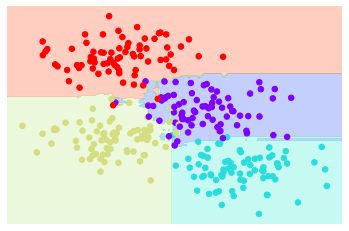

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Vemos que al promediar más de 100 modelos perturbados aleatoriamente, terminamos con un modelo general que está mucho más cerca de nuestra intuición sobre cómo se debe dividir el espacio de parámetros.

## Regresión de bosque aleatorio

En la sección anterior, consideramos los bosques aleatorios dentro del contexto de la clasificación. También se puede hacer que los bosques aleatorios funcionen en el caso de regresión (es decir, variables continuas en lugar de categóricas). El estimador a usar para esto es el RandomForestRegressor, y la sintaxis es muy similar a la que vimos antes.

Considere los siguientes datos, extraídos de la combinación de una oscilación rápida y lenta:

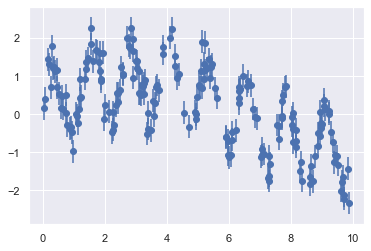

In [12]:
#se declara la variable rng que usa el método random de Numpy RandomState, 
#este expone una serie de métodos para generar números aleatorios extraídos de una variedad de distribuciones de probabilidad
rng = np.random.RandomState(42)
#Luego se declara x y se inicializa usando rng para generar los valores aleatorios de x uniformemente distribuidos
x = 10 * rng.rand(200)

#Definimos una función que será el modelo de regresión
def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

#Usamos el modelo
y = model(x)
#Usamos plt.errorbar para trazar una grafica con barras de error adjuntas
plt.errorbar(x, y, 0.3, fmt='o');

Usando el regresor de bosque aleatorio **RandomForestRegressor**, podemos encontrar la curva de mejor ajuste de la siguiente manera:

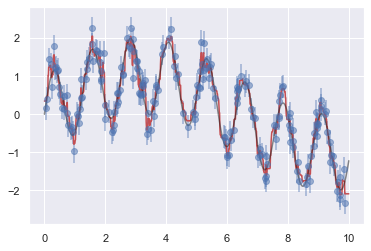

In [13]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Aquí, el modelo real se muestra en la curva gris uniforme, mientras que el modelo de bosque aleatorio se muestra en la curva roja irregular. Como puede ver, el modelo de bosque aleatorio no paramétrico es lo suficientemente flexible como para adaptarse a los datos de varios períodos, ¡sin que tengamos que especificar un modelo de varios períodos!

**Debido a que un bosque aleatorio se puede usar tanto para tareas de clasificación como de regresión, es muy versátil. Puede manejar fácilmente funciones binarias y numéricas, así como categóricas, sin necesidad de transformación o un nuevo escalado. A diferencia de casi cualquier otro modelo, es increíblemente eficiente con todo tipo de datos.**

## Ejemplo: Bosque aleatorio para clasificar dígitos 

En el siguiente ejemplo es sobre cómo realizar la clasificación de dígitos usando el modelo de Bosque Aleatorio en Machine Learning.

Primero importamos la data, luego alamacenamos la data en una variable llamada **name**

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
#Muestra un arreglo con las palabras clave del dataset, que contienen información sobre este
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

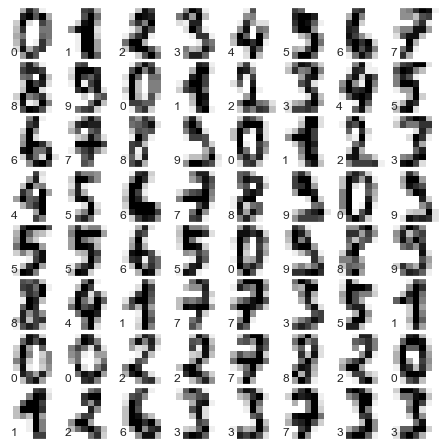

In [15]:
# configuramos la figura
fig = plt.figure(figsize=(6, 6))  # Seteamos el tamaño de la figura en pulgadas
#seteamos la configuración de las subfiguras(los nuemros)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# graficamos los dígitos: cada imagen es de 8x8 píxeles
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # etiquetamos la imágenes con el valor dígito
    ax.text(0, 7, str(digits.target[i]))

El resultado es un conjunto de números que están demasiado borrosos y pixeleados, la idea es clasificarlos usando un Bosque Aleatorio, como se muestra a continuación:

In [16]:
from sklearn.model_selection import train_test_split

#creamos el conjunto de entrenamiento y prueba (Xtrain, ytrain)
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)

#Definimos el modelo de bosque aleatorio con un número de estimadores de 1000
model = RandomForestClassifier(n_estimators=1000)
#Ajustamos el estimador
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Ahora ya podemos revisar los resultados que arroja el informe de clasificación:

In [17]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.96      0.98        45
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Y para mejor visualización y comprensión gráfica, trazamos la matriz de confusión:

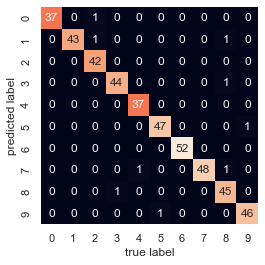

In [18]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

**Conclusión del ejercicio:** Sintetizando estos datos, podemos decir que según los datos que arrojó el reporte de clasificación y la matriz de confusión,  los resultados de la clasificación son bastante precisos y el **Modelo de Bosque Aleatorio** es poco propenso a fallos debido al alto numero de arboles de desición que debieron ser usados, por lo que una razón de esta alta presición es el uso de una cantidad de árboles con diferencias significativas entre los subgrupos y esto hace que los bosques aleatorios sean una herramienta de clasificación muy precisa.

## Conclusión

Random Forest es un técnica de aprendizaje automático supervisada basada en árboles de decisión. Su principal ventaja es que obtiene un mejor rendimiento de generalización para un rendimiento durante entrenamiento similar. Esta mejora en la generalización la consigue compensando los errores de las predicciones de los distintos árboles de decisión. Para asegurarnos que los árboles sean distintos, lo que hacemos es que cada uno se entrena con una muestra aleatoria de los datos de entrenamiento. Esta estrategia se denomina bagging(embolsado).